In [27]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import models


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import os
from pathlib import Path
data_path = Path("/content/drive/My Drive/Datathon CBRE DSC/img/")
img_path = data_path / 'DSC Datathon IMG'

In [32]:
def walk_through_dir(dir_path):
  """Walks through dir_path, returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [33]:
walk_through_dir(img_path)

There are 5 directories and 456 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG'.
There are 0 directories and 17 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/4'.
There are 0 directories and 73 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/1'.
There are 0 directories and 48 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/5'.
There are 0 directories and 16 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/3'.
There are 0 directories and 71 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/2'.


/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/2/1652891933_2.png
Random image path: /content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/2/1652891933_2.png
Image Class: 2
Image height: 440
Image width: 838


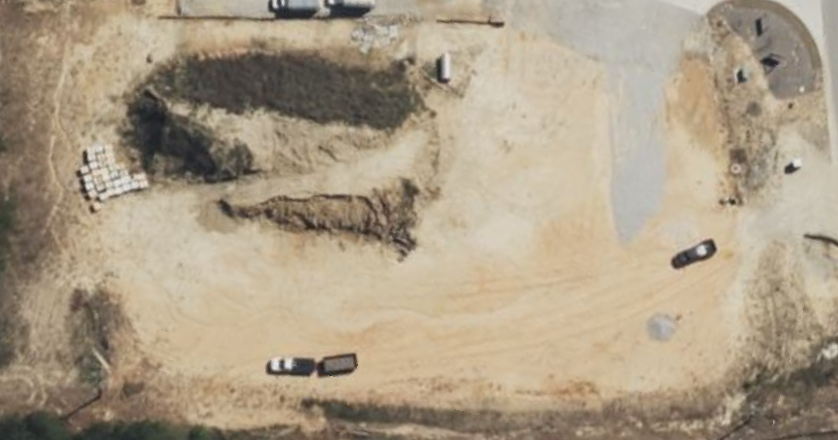

In [34]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths
img_path_list = list(img_path.glob("*/*.png"))


# 2. Pick a random image path
random_image_path = random.choice(img_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem


# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [35]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [36]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,

               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0
  model.to(device)
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
  return train_loss, train_acc

In [37]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)

      test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

    test_loss /= len(data_loader)

    test_acc /= len(data_loader)

  print(f"Test loss: {test_loss:.4f}, test acc: {test_acc:.2f}%")
  return test_loss, test_acc

In [38]:
from torch.optim.lr_scheduler import StepLR
model = models.vgg16(pretrained = True)
num_classes = 5
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
data_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(128, 128), antialias=True),
    transforms.RandomRotation((-0.25,0.25)),
    transforms.RandomVerticalFlip(),

    transforms.ToTensor()
])

In [40]:

from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets
from sklearn.model_selection import train_test_split


dataset = datasets.ImageFolder(root=img_path, transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
new_batch_size = 78
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

In [41]:
print(img_path)

/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG


In [42]:
len(train_dataloader), len(test_dataloader)

(180, 45)

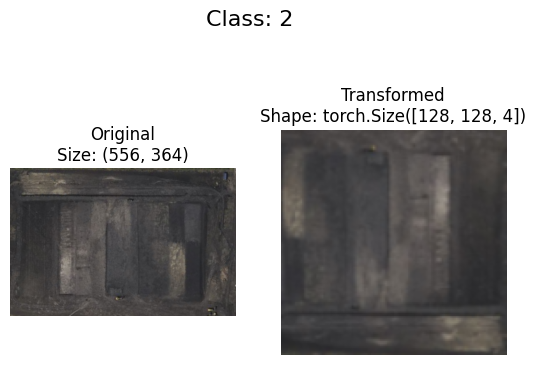

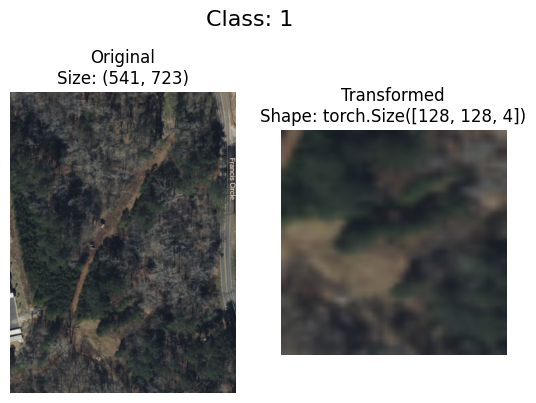

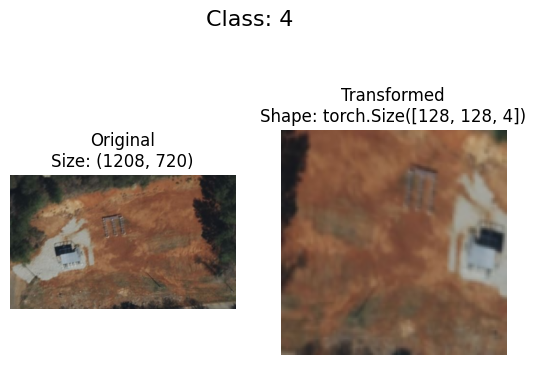

In [43]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from path of images and loads/transforms them and plots
  original vs transformed images
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = img_path_list, transform = data_transform, n=3, seed=42)

In [44]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          scheduler: torch.optim.lr_scheduler,  # Add scheduler here
          epochs: int,
          device=device):

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in tqdm(range(epochs)):
        # Training phase
        model.train()
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            # Compute accuracy and record training loss
            acc = accuracy_fn(y, y_pred.argmax(dim=1))
            results["train_loss"].append(loss.item())
            results["train_acc"].append(acc)

        # Scheduler step
        scheduler.step()  # Update the learning rate

        # Evaluation phase
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                acc = accuracy_fn(y, y_pred.argmax(dim=1))
                results["test_loss"].append(loss.item())
                results["test_acc"].append(acc)

        print(f"Epoch: {epoch} | "
              f"Train loss: {np.mean(results['train_loss']):.4f} | "
              f"Train acc: {np.mean(results['train_acc']):.2f}% | "
              f"Test loss: {np.mean(results['test_loss']):.4f} | "
              f"Test acc: {np.mean(results['test_acc']):.2f}%")

    return results

In [45]:
torch.manual_seed(42)
NUM_EPOCHS = 100


from timeit import default_timer as timer
start_time= timer()

# Train model 0
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer and print time
end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.5479 | Train acc: 46.11% | Test loss: 1.1606 | Test acc: 55.56%
Epoch: 1 | Train loss: 1.4058 | Train acc: 48.89% | Test loss: 1.1812 | Test acc: 61.11%
Epoch: 2 | Train loss: 1.3075 | Train acc: 51.30% | Test loss: 1.1845 | Test acc: 60.74%
Epoch: 3 | Train loss: 1.2537 | Train acc: 53.06% | Test loss: 1.1385 | Test acc: 60.00%
Epoch: 4 | Train loss: 1.1999 | Train acc: 55.56% | Test loss: 1.1179 | Test acc: 58.22%
Epoch: 5 | Train loss: 1.1535 | Train acc: 56.20% | Test loss: 1.1268 | Test acc: 58.15%
Epoch: 6 | Train loss: 1.1231 | Train acc: 57.22% | Test loss: 1.1938 | Test acc: 55.56%
Epoch: 7 | Train loss: 1.0985 | Train acc: 58.12% | Test loss: 1.1737 | Test acc: 56.67%
Epoch: 8 | Train loss: 1.0754 | Train acc: 58.52% | Test loss: 1.1728 | Test acc: 57.28%
Epoch: 9 | Train loss: 1.0429 | Train acc: 59.94% | Test loss: 1.1943 | Test acc: 56.67%
Epoch: 10 | Train loss: 1.0252 | Train acc: 60.86% | Test loss: 1.1948 | Test acc: 56.16%
Epoch: 11 | Train lo

In [46]:
  # Path to the directory containing the image files
from pathlib import Path
img_path = Path("/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG")
image_dir = list(img_path.glob("*/*.png"))
remaining_quarters_dict = {}
# Path to the CSV file containing size data
atlanta_dat = Path("/content/drive/My Drive/Datathon CBRE DSC/Atlanta_supply_dat.xlsx - Atlanta_dat.csv")
uc_buildings = Path("/content/drive/My Drive/Datathon CBRE DSC/Atlanta_supply_dat.xlsx - UC_buildings.csv")

# Function to extract property_id and stage of construction from a filename
def parse_filename(filename):
    parts = filename.split('_')
    property_id = parts[0]
    stage = parts[1].split('.')[0]  # Remove file extension
    return property_id, stage

# Read the CSV file into a DataFrame
df = pd.read_csv(uc_buildings)

# Function to estimate completion time based on stage of construction and size
def estimate_completion_time(stage, size_sf):
    stage_progress = {
        'Undeveloped': 0,
        'Ground Broken': 25,
        'Concrete Pad': 45,
        'Framing Going up': 85,
        'Near completion or completed': 100
    }
    if size_sf < 100000:
        total_time = 2
    elif 100000 <= size_sf < 300000:
        total_time = 3
    elif 300000 <= size_sf < 600000:
        total_time = 4
    elif 600000 <= size_sf < 1000000:
        total_time = 5
    else:
        total_time = 6

    current_progress = stage_progress.get(stage, 0)
    remaining_time = total_time * (1 - current_progress / 100)
    return round(remaining_time, 2)

# Iterate over each file in the image directory
for img_path in image_dir:
    filename = img_path.name  # Get the filename as a string
    if filename.endswith('.png'):  # Make sure the file extension is correct
        property_id, stage = parse_filename(filename)
        # The following line may need error handling if a property ID is not found
        size_sf = df.loc[df['PropertyID'] == int(property_id), 'Size_sf'].values[0]  # Ensure size_sf is a float
        remaining_quarters = estimate_completion_time(stage, size_sf)
        print(f"Property ID {property_id}, Stage: {stage}, Size: {size_sf} sq ft, Remaining Time: {remaining_quarters} quarters")
        remaining_quarters_dict[int(property_id)] = remaining_quarters
    else:
        print(f"Property ID {property_id} not found in the CSV.")

print(f"Number of image files found: {len(image_dir)}")
remaining_quarters_dict



Property ID 1652887791, Stage: 4, Size: 134850 sq ft, Remaining Time: 3.0 quarters
Property ID 1652900994, Stage: 4, Size: 53780 sq ft, Remaining Time: 2.0 quarters
Property ID 1652918149, Stage: 4, Size: 102957 sq ft, Remaining Time: 3.0 quarters
Property ID 1652908405, Stage: 4, Size: 60000 sq ft, Remaining Time: 2.0 quarters
Property ID 1652810765, Stage: 4, Size: 41923 sq ft, Remaining Time: 2.0 quarters
Property ID 1652907350, Stage: 4, Size: 18000 sq ft, Remaining Time: 2.0 quarters
Property ID 1652912961, Stage: 4, Size: 11700 sq ft, Remaining Time: 2.0 quarters
Property ID 1652894900, Stage: 4, Size: 1076459 sq ft, Remaining Time: 6.0 quarters
Property ID 1652914148, Stage: 4, Size: 176305 sq ft, Remaining Time: 3.0 quarters
Property ID 1652918145, Stage: 4, Size: 188132 sq ft, Remaining Time: 3.0 quarters
Property ID 1652918537, Stage: 4, Size: 100500 sq ft, Remaining Time: 3.0 quarters
Property ID 1652918143, Stage: 4, Size: 134401 sq ft, Remaining Time: 3.0 quarters
Property

{1652887791: 3.0,
 1652900994: 2.0,
 1652918149: 3.0,
 1652908405: 2.0,
 1652810765: 2.0,
 1652907350: 2.0,
 1652912961: 2.0,
 1652894900: 6.0,
 1652914148: 3.0,
 1652918145: 3.0,
 1652918537: 3.0,
 1652918143: 3.0,
 1652869287: 2.0,
 1652896733: 3.0,
 1652887792: 3.0,
 1652909365: 2.0,
 1652926528: 3.0,
 1652886730: 2.0,
 1652894195: 3.0,
 1652917117: 2.0,
 1652923075: 2.0,
 1652901827: 4.0,
 1652892515: 3.0,
 1652892432: 3.0,
 1652894658: 4.0,
 1652916003: 2.0,
 1652901399: 2.0,
 1652924378: 2.0,
 1652893757: 2.0,
 1652914963: 2.0,
 1652899850: 5.0,
 1652900995: 2.0,
 1652891475: 2.0,
 1652901443: 4.0,
 1652922891: 2.0,
 1652891637: 3.0,
 1652924318: 2.0,
 1652887425: 2.0,
 1652909360: 3.0,
 1652909340: 4.0,
 1652909348: 3.0,
 1652924375: 2.0,
 1652886563: 3.0,
 1652911371: 4.0,
 1652918934: 2.0,
 1652823299: 6.0,
 1652901960: 3.0,
 1652889892: 5.0,
 1652851823: 3.0,
 1652906855: 2.0,
 1652923078: 2.0,
 1652908410: 2.0,
 1652918768: 2.0,
 1652885024: 2.0,
 1652896181: 2.0,
 165289419

In [49]:
atlanta_df = pd.read_csv(atlanta_dat)
uc_buildings_df = pd.read_csv(uc_buildings)
property_ids_from_df = set(uc_buildings_df['PropertyID'])



def calculate_adjusted_quarters(quarters):
    return round(quarters * 0.75)

# Convert 'YearQuarterGroundBroken' to periods assuming the input is in the format 'yyyy.Q#'
uc_buildings_df['YearQuarterGroundBroken'] = uc_buildings_df['YearQuarterGroundBroken'].apply(
    lambda x: pd.Period(f"{int(x)}Q1", freq='Q') if pd.notna(x) else pd.NaT
)

# Calculate the adjusted quarters for each PropertyID based on the dictionary
uc_buildings_df['AdjustedQuarters'] = uc_buildings_df['PropertyID'].map(remaining_quarters_dict).apply(calculate_adjusted_quarters)

# Function to add quarters to a period, handling None values
def add_quarters_to_period(period, quarters):
    if pd.isna(period) or quarters is None:
        return None
    return period + quarters

# Calculate estimated completion quarter for each property
uc_buildings_df['EstimatedCompletionYearQuarter'] = uc_buildings_df.apply(
    lambda x: add_quarters_to_period(x['YearQuarterGroundBroken'], x['AdjustedQuarters']),
    axis=1
)

# Convert the period to "yyyy.q" format for easier interpretation, handling None
uc_buildings_df['EstimatedCompletionYearQuarter'] = uc_buildings_df['EstimatedCompletionYearQuarter'].apply(
    lambda x: f"{x.year}.{x.quarter}" if not pd.isna(x) else None
)

# Optionally, convert the DataFrame column to a dictionary if needed
estimated_completion_dict = pd.Series(uc_buildings_df['EstimatedCompletionYearQuarter'].values, index=uc_buildings_df['PropertyID']).to_dict()

filtered_df = uc_buildings_df[uc_buildings_df['MarketCode'] == 'ATLANT']
uc_buildings_df['EstimatedCompletionYearQuarter'] = uc_buildings_df['PropertyID'].map(estimated_completion_dict)


# Group by 'EstimatedCompletionYearQuarter' and sum 'Size_sf' for each group
completion_size_aggregation = filtered_df.groupby('EstimatedCompletionYearQuarter')['Size_sf'].sum()

# Convert the aggregated Series to a dictionary
quarter_size_dict = completion_size_aggregation.to_dict()

# Print the dictionary to verify the results
print(quarter_size_dict)
print(estimated_completion_dict)


new_rows = []

# Append new rows based on quarter_size_dict
for quarter, size_sf in quarter_size_dict.items():
    new_row = pd.DataFrame({
        'MarketCode': ['ATLANT'],
        'MarketName': ['Atlanta'],
        'YearQuarter': [quarter],
        'Completions_sf': [size_sf],

    })
    new_rows.append(new_row)

# Concatenate new rows with the original DataFrame
atlanta_df = pd.concat([atlanta_df] + new_rows, ignore_index=True)

# Print DataFrame to check new rows were added correctly
print("DataFrame after appending new rows:", atlanta_df.tail(10), sep='\n')

# Convert 'YearQuarter' from '2000.1' directly to Period for proper sorting
atlanta_df['YearQuarter'] = atlanta_df['YearQuarter'].astype(float)


# Sort DataFrame by 'YearQuarter'
atlanta_df.sort_values('YearQuarter', inplace=True)

# Calculate 'stock_sf' by updating from the previous value
for i in range(1, len(atlanta_df)):
    if pd.isna(atlanta_df.at[i, 'Stock_sf']):
        atlanta_df.at[i, 'Stock_sf'] = atlanta_df.at[i - 1, 'Stock_sf'] + (atlanta_df.at[i, 'Completions_sf'] if pd.notna(atlanta_df.at[i, 'Completions_sf']) else 0)

# Convert 'YearQuarter' back to 'yyyy.Q' format for display purposes
atlanta_df['YearQuarter'] = atlanta_df['YearQuarter'].astype(str)

# Save the updated DataFrame back to CSV
atlanta_df.to_csv("/content/drive/My Drive/Datathon CBRE DSC/Updated_Atlanta_supply_dat.csv", index=False)
atlanta_df

{'2021.3': 45000, '2022.3': 864549, '2022.4': 2056157, '2023.1': 800000, '2023.3': 3164489, '2023.4': 3723862, '2024.1': 4612690, '2024.3': 741170, '2025.1': 2044826}
{1652916003: '2024.3', 1652901399: '2023.3', 1652907044: '2023.3', 1652887791: '2023.3', 1652900810: '2023.3', 1652905346: '2023.3', 1652916988: '2023.3', 1652917708: '2023.3', 1652918149: '2023.3', 1652901443: '2024.4', 1652900812: '2022.3', 1652905347: '2023.3', 1652913670: '2023.3', 1652926522: '2024.3', 1652926669: '2023.3', 1652908405: '2023.3', 1652909449: '2023.3', 1652876296: '2022.4', 1652901960: '2023.3', 1652810765: '2023.3', 1652889892: '2023.1', 1652914737: '2023.3', 1652907350: '2022.3', 1652851823: '2021.3', 1652915224: '2023.4', 1652912961: '2023.3', 1652906855: '2024.3', 1652894900: '2024.1', 1652923078: '2023.3', 1652893067: '2023.3', 1652908410: '2023.3', 1652918768: '2023.3', 1652885024: '2022.3', 1652896181: '2022.3', 1652894196: '2022.3', 1652909835: '2023.4', 1652901733: '2023.3', 1652923517: '2024.

,MarketCode,MarketName,YearQuarter,Stock_sf,Completions_sf,Stock_Under_Construction_sf,under_construction_as_a_percentage_of_Stock
0,ATLANT,Atlanta,2000.1,397465.0,4394,4098.0,1.031
1,ATLANT,Atlanta,2000.2,401081.0,3616,6109.0,1.523
2,ATLANT,Atlanta,2000.3,405850.0,4769,5352.0,1.319
3,ATLANT,Atlanta,2000.4,412672.0,6822,7892.0,1.912
4,ATLANT,Atlanta,2001.1,416867.0,4195,8298.0,1.991
...,...,...,...,...,...,...,...
95,ATLANT,Atlanta,2023.4,730346.0,12669,21891.0,2.997
101,ATLANT,Atlanta,2023.4,11384403.0,3723862,NaN,NaN
102,ATLANT,Atlanta,2024.1,15997093.0,4612690,NaN,NaN
103,ATLANT,Atlanta,2024.3,16738263.0,741170,NaN,NaN
